Upload file CSV kamu (mis. TGM_2020-2023_eng.csv)


Saving TGM_2020-2023_eng[1].csv to TGM_2020-2023_eng[1].csv
Kolom terbaca: ['Provinsi', 'Year', 'Reading Frequency per week', 'Number of Readings per Quarter', 'Daily Reading Duration (in minutes)', 'Internet Access Frequency per Week', 'Daily Internet Duration (in minutes)', 'Tingkat Kegemaran Membaca (Reading Interest)', 'Category']

Ringkasan awal (sebelum bersih):
                                              count        mean        std  \
Reading Frequency per week                    140.0    4.664286   0.601087   
Number of Readings per Quarter                140.0    4.221429   1.329347   
Daily Reading Duration (in minutes)           140.0   98.223571  12.042064   
Internet Access Frequency per Week            105.0    5.395238   0.603257   
Daily Internet Duration (in minutes)          105.0  113.378095  11.771731   
Tingkat Kegemaran Membaca (Reading Interest)  140.0   61.201000   6.286484   

                                                min       25%      50%  \
Reading 

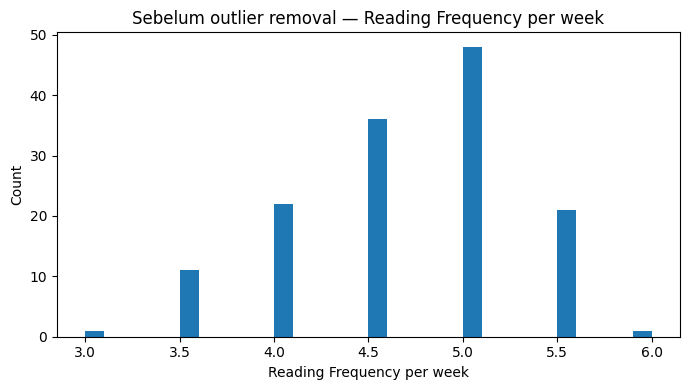

Reading Frequency per week -> lower=3.750, upper=5.750


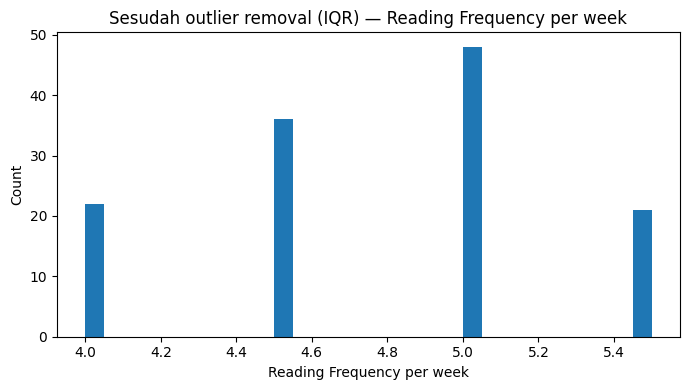

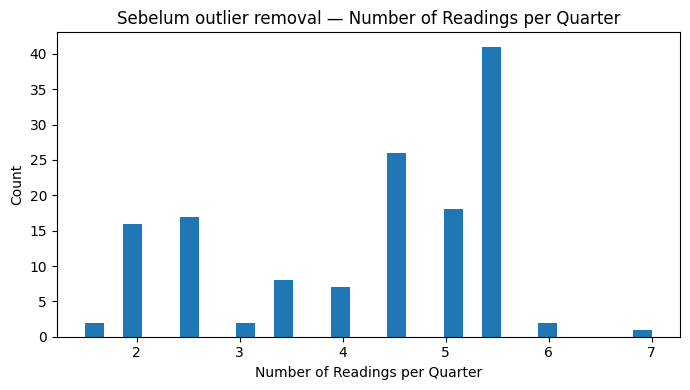

Number of Readings per Quarter -> lower=0.500, upper=8.500


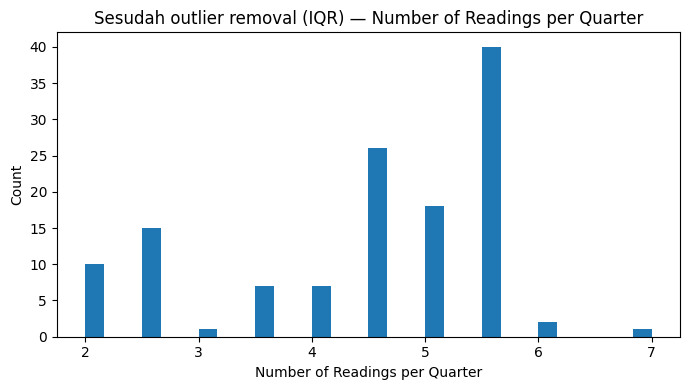

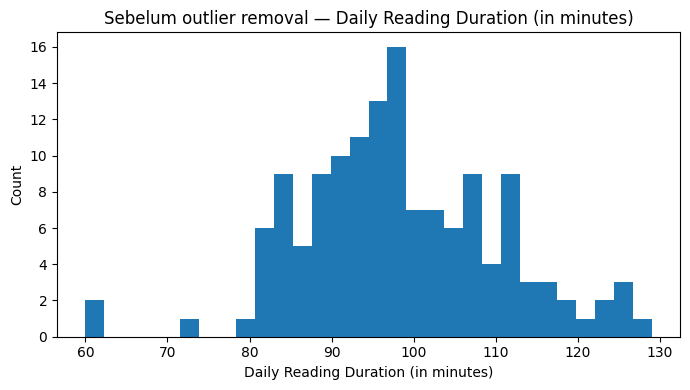

Daily Reading Duration (in minutes) -> lower=70.150, upper=128.150


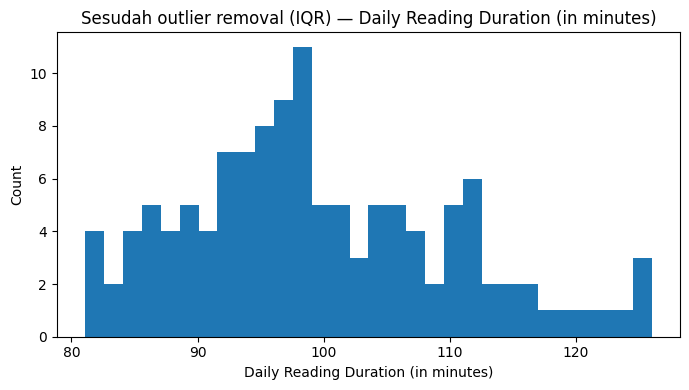

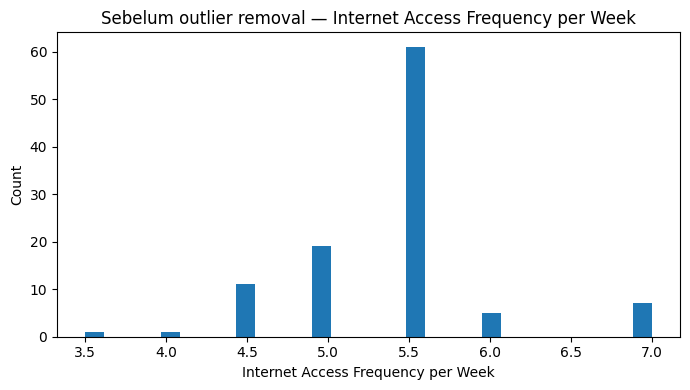

Internet Access Frequency per Week -> lower=4.250, upper=6.250


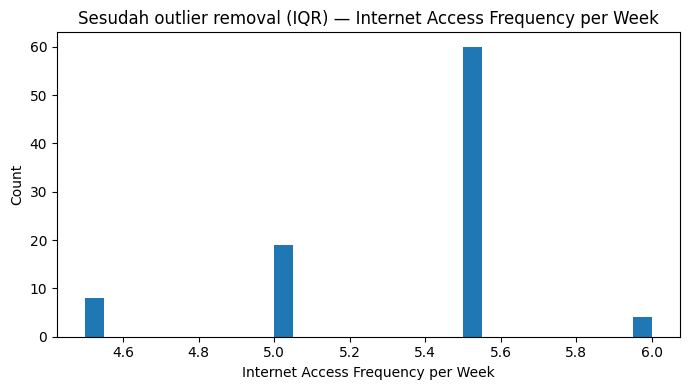

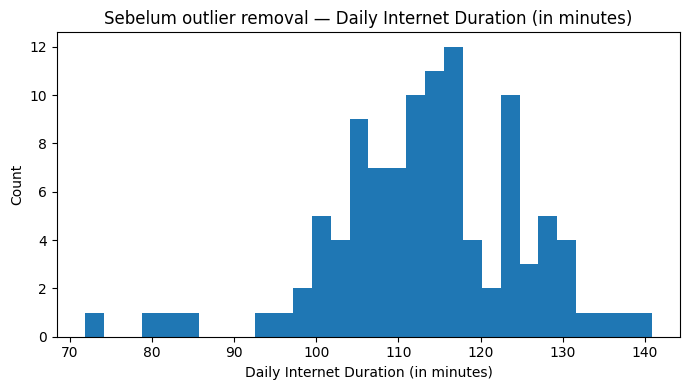

Daily Internet Duration (in minutes) -> lower=86.300, upper=140.700


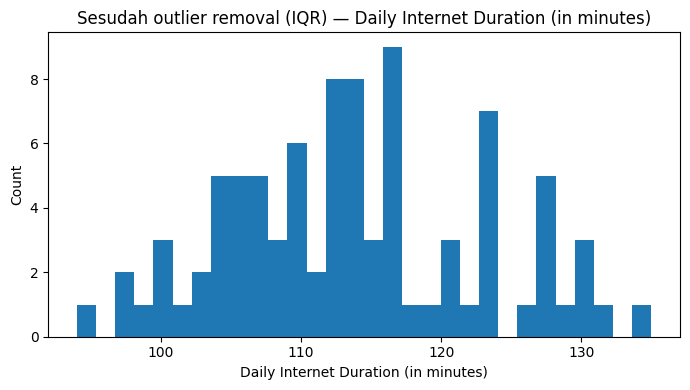

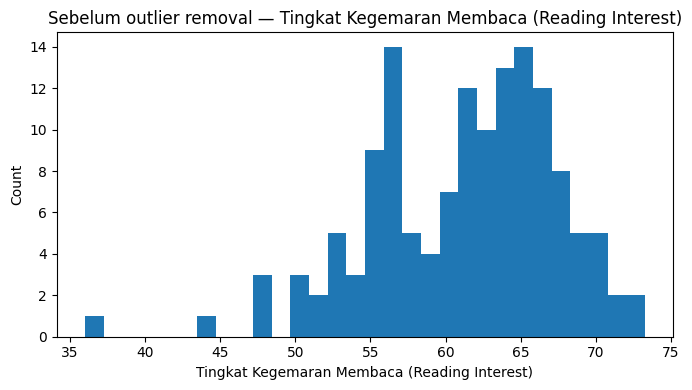

Tingkat Kegemaran Membaca (Reading Interest) -> lower=45.306, upper=77.756


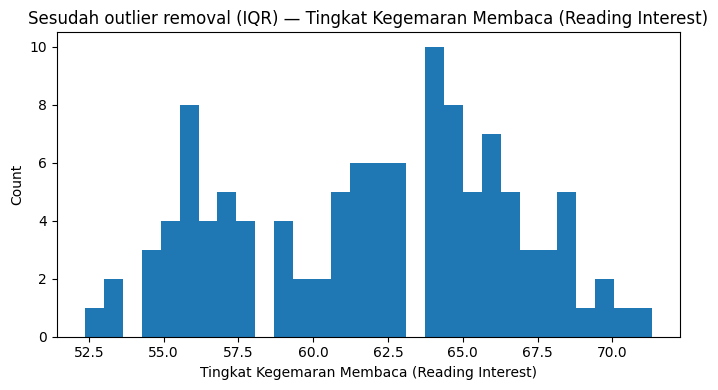


Jumlah baris: sebelum = 140  | sesudah = 113

Ringkasan sesudah (setelah IQR semua kolom):
                                              count        mean        std  \
Reading Frequency per week                    113.0    4.738938   0.463379   
Number of Readings per Quarter                113.0    4.327434   1.229783   
Daily Reading Duration (in minutes)           113.0   99.250442  10.459190   
Internet Access Frequency per Week             88.0    5.329545   0.354660   
Daily Internet Duration (in minutes)           88.0  113.850000   9.148695   
Tingkat Kegemaran Membaca (Reading Interest)  113.0   62.050708   4.603546   

                                                min     25%    50%     75%  \
Reading Frequency per week                     4.00    4.50    5.0    5.00   
Number of Readings per Quarter                 2.00    3.50    4.5    5.50   
Daily Reading Duration (in minutes)           81.10   91.80   98.0  106.00   
Internet Access Frequency per Week             4.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Selesai ✅ Gambar histogram disimpan sebagai 'hist_before_*' dan 'hist_after_*'.


In [1]:
# === Full pipeline: upload -> read -> clean -> IQR -> hist -> save ===
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# 1) Upload
print("Upload file CSV kamu (mis. TGM_2020-2023_eng.csv)")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 2) Baca CSV (robust terhadap delimiter ; atau , serta BOM)
def read_smart_csv(path):
    # 'NA', 'N/A' dianggap NaN
    na_vals = ["NA", "N/A", "NaN", ""]
    last_err = None
    for args in (
        dict(sep=None, engine="python"),  # auto-deteksi pemisah
        dict(sep=";"),
        dict(sep=","),
    ):
        try:
            return pd.read_csv(path, encoding="utf-8-sig", na_values=na_vals, **args)
        except Exception as e:
            last_err = e
    raise last_err

df = read_smart_csv(filename)
print("Kolom terbaca:", list(df.columns))

# 3) Daftar kolom numerik (hanya yang ada di file)
candidate_numeric = [
    "Reading Frequency per week",
    "Number of Readings per Quarter",
    "Daily Reading Duration (in minutes)",
    "Internet Access Frequency per Week",
    "Daily Internet Duration (in minutes)",
    "Tingkat Kegemaran Membaca (Reading Interest)",
]
numeric_cols = [c for c in candidate_numeric if c in df.columns]
assert numeric_cols, "Tidak menemukan kolom numerik yang diharapkan."

# 4) Normalisasi angka: ganti koma -> titik lalu ke float
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", ".", regex=False),
                            errors="coerce")

print("\nRingkasan awal (sebelum bersih):")
print(df[numeric_cols].describe().T)

# 5) Fungsi batas IQR
def iqr_bounds(series):
    s = series.dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return lower, upper

# 6) Plot histogram & hapus outlier per kolom (NaN tidak dihapus di langkah ini)
clean = df.copy()
def safe_name(s):  # untuk nama file gambar
    return s.replace(" ", "_").replace("(", "").replace(")", "")

for col in numeric_cols:
    # Histogram SEBELUM
    plt.figure(figsize=(7,4))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Sebelum outlier removal — {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"hist_before_{safe_name(col)}.png")
    plt.show()

    # Hitung batas IQR & filter
    lb, ub = iqr_bounds(clean[col])
    print(f"{col} -> lower={lb:.3f}, upper={ub:.3f}")
    # keep NaN; buang hanya yang benar-benar di luar batas
    mask_in = clean[col].isna() | ((clean[col] >= lb) & (clean[col] <= ub))
    clean = clean[mask_in]

    # Histogram SESUDAH (pakai data yang sudah difilter bertahap)
    plt.figure(figsize=(7,4))
    plt.hist(clean[col].dropna(), bins=30)
    plt.title(f"Sesudah outlier removal (IQR) — {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"hist_after_{safe_name(col)}.png")
    plt.show()

# 7) Ringkasan perbandingan
print("\nJumlah baris: sebelum =", len(df), " | sesudah =", len(clean))
print("\nRingkasan sesudah (setelah IQR semua kolom):")
print(clean[numeric_cols].describe().T)

# 8) Simpan hasil
clean.to_csv("TGM_2020-2023_clean.csv", index=False)
clean.to_excel("TGM_2020-2023_clean.xlsx", index=False)

# 9) Download hasil
files.download("TGM_2020-2023_clean.csv")
files.download("TGM_2020-2023_clean.xlsx")

print("\nSelesai ✅ Gambar histogram disimpan sebagai 'hist_before_*' dan 'hist_after_*'.")
